# How to load the Data

Software setup:

```bash
conda create --name tool-tracking_env python=3.7
conda activate tool-tracking_env
pip install -r requirements.txt
jupyter notebook
```

## 0. Structure of Tool Tracking Data

You have one dedicated folder for each __(hand) tool__. On the next level are folders for each __measurement campaign__. The undermost level contains all __measurements__ of the corresponding measurement campaign.

The preferred way to access the data for analysis and learning is using the `data-tools` package which is part of this repository.

![data_structure](./info/structure_scheme.jpg)

## 1. Load Data with `data-tools`

First we have to connect to our downloaded data using the main class:

In [1]:
from pathlib import Path
from datatools.fixture import setup_dummy_data
source = setup_dummy_data(5)

In [2]:
from datatools import MeasurementDataReader, Measurement, MeasurementSeries, Action
mdr = MeasurementDataReader(source=source)

### 1.1 Create a Query to load _Measurements_ or _Actions_

Using the `mdr` object we can create a `Query` object to formulate a query to the data source.

In [3]:
q = mdr.query(query_type=Measurement)

Depending on the use case you can query for _Measurements_ which represents a temporal contiguous time series with inhomogeneous labels or _Actions_ which are parts of _Measurements_ but have the same label throughout their time range:

```python
from datatools import Action
q = mdr.query(query_type=Action)
```

### 1.2 Narrow a Query to load _Measurements_ of interest

In [4]:
from datatools import Tool, Config, MeasurementSeries, Measurement, DataTypes, Action
from datatools import ACC, GYR, MAG, MIC, POS, VEL

data_dict = q.filter_by(Tool == "test_tool", DataTypes == ACC).get()

[INFO] Read annotation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 112.35it/s, file=data-05.annotation]

[INFO] Preparing data from:
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
[INFO] Finished with 5 measurement(s).


In [5]:
data_dict.keys()  # we have loaded five measurements 

dict_keys(['01', '02', '03', '04', '05'])

In [6]:
data_bunch = data_dict["01"] # data bunch for measurement with measurement id "01"
type(data_bunch)  

datatools.data.DataBunch

### 1.3 Interaction with the `DataBunch` class

A DataBunch object is a dictionary-like object that exposes its keys as attributes. Access the data with `data_bunch.acc` or `data_bunch['audio']`. You can inspect which data is contained with:

In [7]:
data_bunch.data_keys()

['acc']

In [8]:
data_bunch.acc.features

['feature0', 'feature1', 'feature2']

In [9]:
# matrix with raw sensor data with time column
Xt = data_bunch.acc.ts # numpy array

# matrix with raw sensor data (without time column)
X = data_bunch.acc.X  # numpy array

# target vector
y = data_bunch.acc.y  # numpy array

In [10]:
print("shape of Xt: ", Xt.shape)
print("shape of X: ", X.shape)
print("shape of y: ", y.shape)

shape of Xt:  (50, 4)
shape of X:  (50, 3)
shape of y:  (50,)


### 1.4 Narrow a Query to load _Actions_ of interest

In [11]:
data_dict = mdr.query(query_type=Action).filter_by(Action == "no_action").get()

[INFO] Read annotation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.89it/s, file=data-05.annotation]

[INFO] Preparing data from:
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202


[INFO] Finished with 65 action(s).


In [12]:
data_dict.keys()  # the data is now grouped by actions

dict_keys(['no_action'])

In [13]:
data_bunches = data_dict["no_action"]
print(f"{type(data_bunches)} of {type(data_bunches[0])}")

<class 'list'> of <class 'datatools.data.DataBunch'>


## 2. Create windowed Time-Series

In [14]:
import numpy as np
from seglearn.base import TS_Data
from seglearn.pipe import Pype
from fhgutils import Segment, contextual_recarray_dtype, filter_ts_data
from datatools import to_ts_data

> Note: `to_ts_data` can deal with the output when querying _Measurements_ as well as _Actions_

Have a look on the seglearn [user guide](https://dmbee.github.io/seglearn/user_guide.html) to understand the data representation with `Xt` and `Xc`.

In [15]:
window_length=0.2 # unit in s
overlap = 0.5 # unit in percent

# clean and window data
data_dict = mdr.query().filter_by(Tool == "test_tool").get()
Xt, Xc, y = to_ts_data(data_dict, contextual_recarray_dtype)

X = TS_Data(Xt, Xc)
pipe = Pype([
    ('segment', Segment(window_length=window_length, overlap=overlap, enforce_size=True, n=len(np.unique(Xc.desc))))
])

X_trans, y_trans = pipe.fit_transform(X, y)

[INFO] Read annotation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.56it/s, file=data-05.annotation]

[INFO] Preparing data from:
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
  C:\Users\wllr\AppData\Local\Temp\tmpwy381wvu\test_tool\test-00-20200202
[INFO] Finished with 5 measurement(s).
[INFO] segment ['acc' 'gyr'] together
[INFO] segment ['acc' 'gyr'] together
[INFO] segment ['acc' 'gyr'] together
[INFO] segment ['acc' 'gyr'] together
[INFO] segment ['acc' 'gyr'] together
Segment: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 14988.58it/s]


### 2.1 Filter windowed Data

In [16]:
print("[INFO] extract segmented ACC data")
Xt_acc, Xc_acc, y_acc = filter_ts_data(X_trans, y_trans, filt={'desc': ['acc']})

print("[INFO] extract segmented GYR data")
Xt_gyr, Xc_gyr, y_gyr = filter_ts_data(X_trans, y_trans, filt={'desc': ['gyr']})

[INFO] extract segmented ACC data
[INFO] extract segmented GYR data


In [17]:
print("[INFO] shape of ACC data is", Xt_acc.shape)
print("[INFO] shape of GYR data is", Xt_gyr.shape)

print(f"[INFO] {Xt_acc.shape[0]} windows with {Xt_acc.shape[1]} sample each (time stamps and 3 axis accelerometer)")

[INFO] shape of ACC data is (15, 20, 4)
[INFO] shape of GYR data is (15, 20, 4)
[INFO] 15 windows with 20 sample each (time stamps and 3 axis accelerometer)


You can discard the time column with e.g.:
```python
Xt_acc = Xt_acc[:,:,1:]
```

### 2.2 Plot the Toy Data
> Note: In this example we deal with randomly generated toy data!

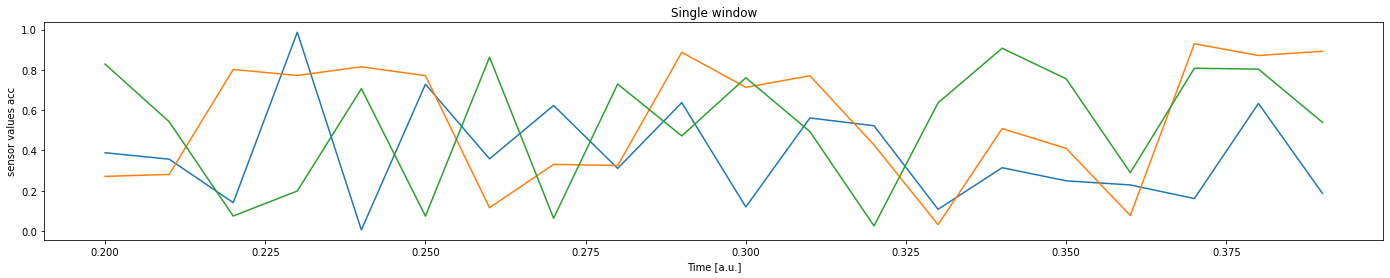

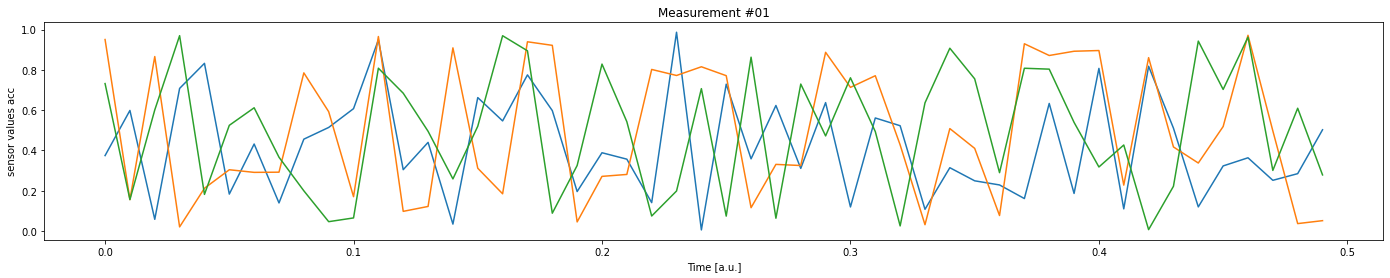

In [18]:
import matplotlib.pyplot as plt
# plot a sample
plt.figure(figsize=(24,4))
plt.title("Single window")
t = Xt_acc[8][:, 0]
x_win = Xt_acc[8][:, 1:]
plt.plot(t, x_win)
plt.xlabel('Time [a.u.]')
plt.ylabel('sensor values acc')
plt.show()

# plot a measurement
plotme = data_dict["01"].acc.ts
t = plotme[:, 0]
x_mea = plotme[:, 1:]
plt.figure(figsize=(24,4))
plt.title("Measurement #01")
plt.plot(t, x_mea)
plt.xlabel('Time [a.u.]')
plt.ylabel('sensor values acc')
plt.show()

## 3. Preprocess the Data

In [19]:
from fhgutils import filter_labels, one_label_per_window, summarize_labels

### 3.1 `filter_labels`
- filter out labels [-1]
- also filter out whole windows, in case there is no majority label 
- e.g. window length of 5, labels could be [1,1,1,1,0] -> okay. but if [1,1,0,0,2] -> discard window.

In [20]:
values, counts = np.unique(y_acc, return_counts=True)
for val, count in zip(values, counts):
    print(f"[INFO] label {val} with {count} samples")

[INFO] label 0.0 with 135 samples
[INFO] label 1.0 with 165 samples


In [21]:
Xt_acc_f, Xc_acc_f, y_acc_f = filter_labels(labels=[-1], Xt=Xt_acc, Xc=Xc_acc, y=y_acc)

[INFO] original Xt: 15 (20, 4)
[INFO] filtered Xt: 10 (20, 4)


### 3.2 `one_label_per_window`
- flatten labels of windows to the majority label
- `[1,1,1,1,2]` -> 1. bad if you've got `[0,0,0,0,0,1,1,1,1,1,1]` -> 1, this creates anomalous samples of class 1

In [22]:
print("pre", y_acc_f[5])
y_acc_f = one_label_per_window(y=y_acc_f)
print("post", y_acc_f[5])

pre [1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
flattened 1 labels: [1]
post 1


### 3.3 `summarize_labels`
- some labels are basically very similar, like "pull_trigger, pull_trigger_air" for the Pneumatic Rivet Gun
- same action, but once holding the tool in the air, once using it on a workpiece.

In [23]:
summarylabels = {5: [0, 1]} 
y_acc_f_sum = summarize_labels(y_acc, summarylabels)

[INFO] Summarized labels from [0. 1.] to [5.]
